<a href="https://colab.research.google.com/github/stygian2a/RoombaGym/blob/master/Roomba.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TODO


In [0]:
#!pip uninstall keras -y   > /dev/null 2>&1
#!pip install keras==2.2.4   > /dev/null 2>&1

!pip uninstall tensorflow -y   > /dev/null 2>&1
!pip install tensorflow==1.14.0  > /dev/null 2>&1

#remove " > /dev/null 2>&1" to see what is going on under the hood
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1
!apt-get install x11-utils > /dev/null 2>&1
#!pip install keras-rl   > /dev/null 2>&1

!pip uninstall stable-baselines -y 
!pip install stable-baselines

!wget https://raw.githubusercontent.com/stygian2a/RoombaGym/master/rendering.py

Requirement already up-to-date: setuptools in /usr/local/lib/python3.6/dist-packages (46.0.0)
Uninstalling stable-baselines-2.2.1:
  Successfully uninstalled stable-baselines-2.2.1
     |████████████████████████████████| 256kB 9.4MB/s 


--2020-03-14 18:14:31--  https://raw.githubusercontent.com/stygian2a/RoombaGym/master/rendering.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11819 (12K) [text/plain]
Saving to: ‘rendering.py’

rendering.py        100%[===================>]  11.54K  --.-KB/s    in 0s      

2020-03-14 18:14:32 (184 MB/s) - ‘rendering.py’ saved [11819/11819]



In [0]:
import gym
from gym import spaces
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython.display import clear_output
from time import sleep
from scipy.stats import multivariate_normal

from IPython import display as ipythondisplay

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [0]:
!dpkg --configure -a
!apt-get install xvfb

Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.4).
0 upgraded, 0 newly installed, 0 to remove and 84 not upgraded.


In [0]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [0]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

## Environment

In [0]:
class Roomba():
  def __init__(self, pos, direction, radius, battery, turn_angle=np.pi/9):
    self.pos = np.array(pos)
    self.direction = direction
    self.radius = radius
    self.turn_angle = turn_angle
    self.battery = battery
    self.max_battery = battery

  def set_pos(self, pos):
    self.pos = np.array(pos)

  def set_direction(self, direction):
    self.direction = np.array(direction)

  def get_forward(self, direction=None):
    if direction == None:
      direction = self.direction
    new_x = np.sin(direction) + self.pos[0]
    new_y = np.cos(direction) + self.pos[1]
    return [new_x, new_y]

  def get_backward(self, direction=None):
    if direction == None:
      direction = self.direction
    new_x = np.sin(direction+np.pi) + self.pos[0]
    new_y = np.cos(direction+np.pi) + self.pos[1]
    return [new_x, new_y]

  def turn_right(self):
    return (self.direction - self.turn_angle) % (2*np.pi)

  def turn_left(self):
    return (self.direction + self.turn_angle) % (2*np.pi)

  def decrease_battery(self):
    self.battery -=1

  def recharge_battery(self):
    self.battery = self.max_battery

  def get_life(self):
    return self.battery / self.max_battery


  #https://stackoverflow.com/questions/49551440/python-all-points-on-circle-given-radius-and-center
  def get_cases_underneath(self, xmax, ymax, pos = None):
    if pos == None:
      pos = self.pos
    radius = self.radius
    x0 = pos[0] - 0.5
    y0 = pos[1] - 0.5

    L = []
    x_ = np.arange(x0 - radius - 1, x0 + radius + 1, dtype=int)
    y_ = np.arange(y0 - radius - 1, y0 + radius + 1, dtype=int)
    x, y = np.where((x_[:,np.newaxis] - x0)**2 + (y_ - y0)**2 <= radius**2)
    for x, y in zip(x_[x], y_[y]):
      if x>=0 and y>=0 and x<xmax and y<ymax:
        L.append((x, y))
    return L

In [0]:
class RoombaEnv(gym.Env):

  metadata = {
      'render.modes': ['human', 'rgb_array'],
      'video.frames_per_second' : 50
  }

  def __init__(self, height, width, battery, roomba_radius=2, N_grid = 4):
    super(RoombaEnv, self).__init__()

    self.action_space = spaces.Discrete(4) #Forward, Backwards, Right, Left

    """                                      
    self.observation_space = spaces.Tuple([
        spaces.Box(low=0, high=4, shape=(height, width), dtype=np.float32), #1=cleanable, 2=wall, 3=charging station
        spaces.Box(low=np.array([0, 0, 0, 0]), high=np.array([height, width, 2*np.pi, 1]), dtype=np.float32)
    ])
    """
    #self.observation_space = spaces.Box(low=np.array([0, 0, 0, 0]), high=np.array([1, 1, 2*np.pi, 1]), dtype=np.float32)
    #self.observation_space = spaces.Box(low=np.array(np.zeros(4+height*width)), high=np.concatenate([np.array([1, 1, 2*np.pi, 1]), np.ones(height*width)]), dtype=np.float32)
    #self.observation_space = spaces.Box(low=np.array(np.zeros(4+N_grid*N_grid)), high=np.concatenate([np.array([1, 1, 2*np.pi, 1]), np.ones(N_grid*N_grid)]), dtype=np.float32)
    
    #self.observation_space = spaces.Box(low=np.array(np.zeros((height,width))), high=255*np.ones((height,width)), dtype=np.float32)
    self.observation_space = spaces.Box(low=0, high=255, shape=(height, width, 1), dtype=np.uint8)

    self.width = width
    self.height = height
    self.battery = battery
    self.roomba_radius = roomba_radius

    self.N_grid=N_grid

    self.cases_indexes = np.array( [(i,j) for i in range(height) for j in range(width)] )
    

    self.room = self.empty_room()

    self.viewer = None
    self.init_env()

  def init_env(self):
    #self.roomba = Roomba( [self.height-3, self.width-3], -np.pi/2, self.roomba_radius, self.battery)
    self.roomba = Roomba( [3, 3], -np.pi/2, self.roomba_radius, self.battery)
    self.done = False
    self.iteration = 0
    self.sum_rewards = 0
    self.dirty = np.zeros((self.height, self.width))
    self.dirty[self.room != 1] = 0
    #self.dirt_probabilities = multivariate_normal.pdf(self.cases_indexes, mean=[np.random.uniform(0.4,1)*self.height,np.random.uniform(0.4,1)*self.width], cov=10*np.diag([1,1]))
    self.dirt_probabilities = multivariate_normal.pdf(self.cases_indexes, mean=[self.height/2,self.width/2], cov=10*np.diag([1,1]))
    self.dirt_probabilities = self.dirt_probabilities / np.sum(self.dirt_probabilities)

  def empty_room(self):
    room = np.ones((self.height, self.width))
    for i in range(int(self.width/5)):
      for j in range(int(self.height/5)):
        room[i, j] = 3
    return room

  def wall_room(self):
    room = np.ones((self.height, self.width))
    obstacles = [[i,int(self.width/3.5)] for i in range(int(self.height/4), int(3*self.height/4))]
    obstacles += [[i,int(self.width*(1-1/3.5))] for i in range(int(self.height/4), int(3*self.height/4))]

    for obstIndex in obstacles:
      room[obstIndex[0],obstIndex[1]]= 2
    for i in range(int(self.width/5)):
      for j in range(int(self.height/5)):
        room[-i, -j] = 3
    return room

  def tunnel_room(self):
    room = np.ones((self.height, self.width))
    obstacles = [[i,int(self.width/3.5)] for i in range(int(self.height/2))]
    for obstIndex in obstacles:
      room[obstIndex[0],obstIndex[1]]= 2
    for i in range(int(self.width/5)):
      for j in range(int(self.height/5)):
        room[i, j] = 3
    return room

  def clean_floor(self):
    cases_underneath = self.roomba.get_cases_underneath(self.height, self.width)
    reward = 0
    for case_underneath in cases_underneath:
      if self.room[case_underneath] == 1:
        reward += min(1,self.dirty[case_underneath])
        self.dirty[case_underneath] = 0

      if self.room[case_underneath] == 3:
        if self.roomba.get_life() < 0.3:
          reward += 300
        #reward += (1-self.roomba.get_life())*5
        self.roomba.recharge_battery()
    return reward

  def soil_floor(self):
    i = np.random.choice(self.height * self.width, p=self.dirt_probabilities)
    if self.room[self.cases_indexes[i][0], self.cases_indexes[i][1]] ==1:
      self.dirty[self.cases_indexes[i][0], self.cases_indexes[i][1]] = 1

  def step(self, action):
    self.iteration+=1
    #if random.random() <0.1:
    #  action = random.randint(0,3)
    #current_reward = 1
    current_reward = 0
    if action == 0:
      new_pos = self.roomba.get_forward()
      if self.is_safe(new_pos):
        self.roomba.set_pos(new_pos)
      #else:
      #  current_reward += -10

    elif action == 1:
      new_pos = self.roomba.get_backward()
      if self.is_safe(new_pos):
        self.roomba.set_pos(new_pos)
      #else:
      #  current_reward += -10

    elif action == 2:
      self.roomba.set_direction(self.roomba.turn_right())

    elif action == 3:
      self.roomba.set_direction(self.roomba.turn_left())
    self.roomba.decrease_battery()
      
    current_reward += self.clean_floor()
    
    #cost of living
    #current_reward -= 1

    self.soil_floor()

    if self.roomba.battery <= 0:
      current_reward += -600

    self.sum_rewards += current_reward

    if self.iteration>=10000 or self.roomba.battery <= 0:
      self.done = True
      
    return self.get_observation(),current_reward,self.done,{}

  def is_safe(self, new_pos):
    x = new_pos[0]
    y = new_pos[1]

    if y < 0 or x < 0 or x >= self.height or y >= self.width:
      return False

    cases_underneath = self.roomba.get_cases_underneath(self.height, self.width, new_pos)
    for case_underneath in cases_underneath:
      if self.room[case_underneath] == 2:
        return False

    return True


  def get_observation(self):
    '''
    #return np.array([self.roomba.pos[0]/self.height, self.roomba.pos[1]/self.width, self.roomba.direction, self.roomba.get_life()])
    map_features = np.zeros((self.N_grid, self.N_grid))
    i_step = self.height / self.N_grid
    j_step = self.width / self.N_grid
    for i in range(self.N_grid):
      for j in range(self.N_grid):
        subgrid = self.dirty[int(i*i_step):int((i+1)*(i_step)), int(j*j_step):int((j+1)*(j_step)) ]
        map_features[i,j] = np.sum(subgrid)/(subgrid.shape[0]*subgrid.shape[1])

    return np.concatenate([np.array([self.roomba.pos[0]/self.height, self.roomba.pos[1]/self.width, self.roomba.direction, self.roomba.get_life()]), map_features.flatten()])

    #return (self.dirty, np.array([self.roomba.pos[0], self.roomba.pos[1], self.roomba.direction, self.roomba.get_life()]))

    '''
    im = self.dirty.copy()
    ci, cj = int(self.roomba.pos[0]), int(self.roomba.pos[1])
    cr = self.roomba_radius
    new_x = min(max(0, int(round(np.sin(self.roomba.direction) + ci))), self.height-1)
    new_y = min(max(0, int(round(np.cos(self.roomba.direction) + cj))), self.width-1)
    I,J=np.meshgrid(np.arange(im.shape[0]),np.arange(im.shape[1]))
    dist=np.sqrt((I-ci)**2+(J-cj)**2)
    eps = 0.5
    im[np.where((dist<=cr+eps)&(dist>=cr-eps))]=5  #*self.roomba.get_life()
    im[new_x, new_y] = 4
    im = 255*im/5
    #im[self.height-1,self.width-1] = self.roomba.get_life()*255
    return np.reshape(im, [self.height, self.width, 1])
  

    
  def reset(self):
    self.init_env()
    return self.get_observation()

  def render(self, mode='human', close=False):
    scale = 6

    screen_width = scale*self.width
    screen_height = scale*self.height


    if self.viewer is None:
      #TODO: remove when it works
      import importlib
      import rendering
      importlib.reload(rendering)

      self.viewer = rendering.Viewer(screen_width, screen_height)

      self.cases = []
      for i in range(self.height):
        self.cases.append([])
        for j in range(self.width):
          x0 = i*scale
          y0 = j*scale
          x1 = (i+1)*scale
          y1 = (j+1)*scale
          case = rendering.FilledPolygon([(y0,x0), (y0,x1), (y1,x1), (y1,x0)])
          self.cases[i].append(case)
          self.viewer.add_geom(case)
      
      circle = rendering.make_circle(radius=self.roomba.radius*scale)
      circle.set_color(1,0,0)
      self.circle=circle
      direction_circle = rendering.make_circle(radius=self.roomba.radius*scale/2) #color?
      direction_circle.add_attr(rendering.Transform(translation=(self.roomba.radius*scale/2,0)))

      tracker = rendering.Compound([circle, direction_circle])

      self.tracker_trans = rendering.Transform()
      tracker.add_attr(self.tracker_trans)
      self.viewer.add_geom(tracker)

      
    for i in range(self.height):
        for j in range(self.width):
          if self.room[i,j] == 0:
            self.cases[i][j].set_color(1,1,1)
          elif self.room[i,j] == 1:
            self.cases[i][j].set_color(1 - 0.5 * min(1,self.dirty[i,j]),1 - 0.5 * min(1,self.dirty[i,j]),1 - 0.5 * min(1,self.dirty[i,j]))
          elif self.room[i,j] == 2:
            self.cases[i][j].set_color(0,0,0)
          elif self.room[i,j] == 3:
            self.cases[i][j].set_color(0.5,0.5,0)


    self.tracker_trans.set_translation(self.roomba.pos[1]*scale, self.roomba.pos[0]*scale)
    self.tracker_trans.set_rotation(self.roomba.direction)
    self.circle.set_color(self.roomba.get_life(),0,0)


    return self.viewer.render(return_rgb_array = mode=='rgb_array')

In [0]:
#env = wrap_env(RoombaEnv(10, 10, 2))
env = wrap_env(RoombaEnv(20, 20, 500, 2, N_grid=2)) #wrap env seems to grow exponentially with H,W?? Maybe scalse
#env = wrap_env(gym.make("CartPole-v0"))
observation = env.reset()

while True:
  
    env.render()
    
    #your agent goes here
    action = env.action_space.sample() 
         
    observation, reward, done, info = env.step(action)
    
    if done:
      break;
            
env.close()
show_video()

## Baseline

In [0]:
#TODO : Think of BETTER FEATURES (better value for turning)

Height = 20
Width = 20
battery = 500
pad = 2

env = wrap_env(RoombaEnv(Height, Width, battery, pad))
possible_actions = [env.roomba.get_forward, env.roomba.get_backward, env.roomba.turn_right, env.roomba.turn_left]

def closestDirt(x, y, mat):
  d = Height+Width
  for k in range(Height): 
    for l in range(Width):  
        if (mat[k][l] == 1): 
            d = min(d, abs(x - k) + abs(y - l))
  return d

def feature1(state, action):
  dirtMap = state[4:].reshape(20,20)
  pos = action()
  turn = isinstance(pos, float)
  BBB = 0
  if turn:
    pos1=possible_actions[0](pos)
    pos2=possible_actions[1](pos)
    x_min2 = max(0,int(pos2[0])-pad)
    x_max2 = min(Height,int(pos2[0])+pad)
    y_min2 = max(0,int(pos2[1])-pad)
    y_max2 = min(Width,int(pos2[1])+pad)
    BBB = np.sum(dirtMap[x_min2:x_max2, y_min2:y_max2])/(pad*pad)
    BBB -= 1/(pad*pad)
    pos=pos1

  x_min = max(0,int(pos[0])-pad)
  x_max = min(Height,int(pos[0])+pad)
  y_min = max(0,int(pos[1])-pad)
  y_max = min(Width,int(pos[1])+pad)
  AAA = np.sum(dirtMap[x_min:x_max, y_min:y_max])/(pad*pad)
  AAA -= turn/(pad*pad)

  return max(AAA, BBB)

def feature2(state, action):
  charger = np.array([Height-3,Width-3])
  life = state[3]
  pos = action()
  turn = isinstance(pos, float)
  distManhattan2 = 10000000
  if turn:
    pos1=possible_actions[0](pos)
    pos2=possible_actions[1](pos)
    distManhattan2 = charger-pos
    distManhattan2 = np.sum(np.abs(distManhattan2))
    pos=pos1
    life -= - 1/500
  distManhattan = charger-pos
  distManhattan = np.sum(np.abs(distManhattan))
  #print(min((1-life)/distManhattan,1))
  return max((1-life)/distManhattan, (1-life)/distManhattan2)

def feature3(state, action):
  dirtMap = state[4:].reshape(20,20)
  pos = action()
  turn = isinstance(pos, float)
  BBB2 = 10000000
  if turn:
    pos1=possible_actions[0](pos)
    pos2=possible_actions[1](pos)
    BBB2 = closestDirt(int(pos2[0]),int(pos2[1]), dirtMap)/(Height+Width)
    BBB2 -= 1/(Height+Width)
    pos=pos1
  BBB = closestDirt(int(pos[0]),int(pos[1]), dirtMap)/(Height+Width)
  BBB -= turn/(Height+Width)
  return min(BBB,BBB2)#BBB

def feature4(state, action):
  return 1

In [0]:
# WITH MAP WITHOUT INTERMEDIATE REWARD FOR CHARGING

# Hyperparameters
alpha = 0.1
gamma = 0.99
epsilon = 0.3

weights = [0, 0, 0, 0]
F = [feature1, feature2, feature3, feature4]

def getQValue(state, action):
  qv = 0
  for i, feature in enumerate(F):
      qv = qv + weights[i] * feature(state, action)
  return qv

for e in range(5):
  done = False
  state = env.reset()
  while not done:
    if random.uniform(0, 1) < epsilon:
        action = env.action_space.sample()
    else:
        q = np.array([getQValue(state, a) for a in possible_actions])
        action = np.argmax(q)

    next_state, reward, done, info = env.step(action)

    action = possible_actions[action]

    next_values = [getQValue(next_state, a) for a in possible_actions]
    next_max = max(next_values)

    alphadiff = alpha * ((reward + gamma * next_max) - getQValue(state, action))
    
    for i, feature in enumerate(F):
        weights[i] = weights[i] + alphadiff * feature(state, action)

    state = next_state

state = env.reset()
while not done:
  env.render()
  q = np.array([getQValue(state, a) for a in possible_actions])
  action = np.argmax(q)

  next_state, reward, done, info = env.step(action)

  action = possible_actions[action]

  next_values = [getQValue(next_state, a) for a in possible_actions]
  next_max = max(next_values)

  alphadiff = alpha * ((reward + gamma * next_max) - getQValue(state, action))
  
  for i, feature in enumerate(F):
      weights[i] = weights[i] + alphadiff * feature(state, action)

  state = next_state

env.close()
show_video()

In [0]:
weights

[-14.734008961875368, -16.51731220179973, 4.526879405505808, 115.5060467166437]

# Keras-rl


## DQN - Big


In [0]:

import numpy as np
import gym

from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Activation, Flatten, Input, Conv2D, MaxPooling2D, Concatenate, Reshape, Lambda
from keras.models import Model

from rl.agents.dqn import DQNAgent
from rl.policy import BoltzmannQPolicy, GreedyQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory

from keras.layers import Dense, Activation, Flatten, Input, Conv2D, MaxPooling2D, Concatenate, Reshape, Lambda
from keras.models import Model

env = RoombaEnv(20, 20, 500, 2) #wrap env seems to grow exponentially with H,W?? Maybe scalse

nb_actions = env.action_space.n


# Next, we build a very simple model.

i = Input(shape=(1,)+env.observation_space.shape)

#input_roomba, input_map = tf.split(i, [4, env.width*env.height], 1)
input_roomba = Lambda(lambda x: x[:,:,0:4])(i)
input_roomba = Flatten()(input_roomba)

input_map = Lambda( lambda x: x[:,:,4:])(i)


map_reshaped = Reshape((env.height, env.width,1))(input_map)

conv = Conv2D(16, kernel_size=(3, 3),
                 activation='relu')(map_reshaped)
conv = MaxPooling2D(pool_size=(2, 2))(conv)
conv = Conv2D(16, kernel_size=(3, 3),
                 activation='relu')(conv)
conv = MaxPooling2D(pool_size=(2, 2))(conv)
conv = Flatten()(conv)
conv = Dense(64)(conv)
conv = Dense(32)(conv)
conv = Dense(16)(conv)

merged = Concatenate()([conv, input_roomba])

merged = Dense(8)(merged)
output = Dense(nb_actions)(merged)

model = Model(inputs=i, outputs=output)
print(model.summary())

# Finally, we configure and compile our agent. You can use every built-in Keras optimizer and
# even the metrics!
memory = SequentialMemory(limit=60000, window_length=1)
policy = BoltzmannQPolicy()
dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=10000,
               target_model_update=4000, policy=policy)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

# Okay, now it's time to learn something! We visualize the training here for show, but this
# slows down training quite a lot. You can always safely abort the training prematurely using
# Ctrl + C.
dqn.fit(env, nb_steps=50000, visualize=False, verbose=2)

# After training is done, we save the final weights.
dqn.save_weights('dqn_roomba_weights.h5f', overwrite=True)

# Finally, evaluate our algorithm for 5 episodes.
dqn.test(env, nb_episodes=5, visualize=False)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           (None, 1, 404)       0                                            
__________________________________________________________________________________________________
lambda_44 (Lambda)              (None, 1, 400)       0           input_22[0][0]                   
__________________________________________________________________________________________________
reshape_22 (Reshape)            (None, 20, 20, 1)    0           lambda_44[0][0]                  
__________________________________________________________________________________________________
conv2d_43 (Conv2D)              (None, 18, 18, 16)   160         reshape_22[0][0]                 
__________________________________________________________________________________________________
max_poolin

In [0]:
env = wrap_env(RoombaEnv(20, 20, 500, 2))

dqn.fit(env, nb_steps=20000, visualize=False, verbose=2)

In [0]:
! rm -rf video/

env = wrap_env(RoombaEnv(20, 20, 500, 2))

dqn.test(env, nb_episodes=5, visualize=True)
            
env.close()
show_video()

Testing for 5 episodes ...
Episode 1: reward: 2.000, steps: 10000
Episode 2: reward: 212.000, steps: 2777
Episode 3: reward: -141.000, steps: 609
Episode 4: reward: 11.000, steps: 10000
Episode 5: reward: -67.000, steps: 1030


In [0]:
! rm -rf video/

env = wrap_env(RoombaEnv(20, 20, 500, 2))

dqn.fit(env, nb_steps=2000, visualize=True, verbose=2)
            
env.close()
show_video()

Training for 2000 steps ...
  615/2000: episode: 1, duration: 10.692s, episode steps: 615, steps per second: 58, episode reward: -95.000, mean reward: -0.154 [-200.000, 4.000], mean action: 1.485 [0.000, 3.000], mean observation: 0.237 [0.000, 6.109], loss: --, mean_absolute_error: --, mean_q: --
 1309/2000: episode: 2, duration: 11.726s, episode steps: 694, steps per second: 59, episode reward: -192.000, mean reward: -0.277 [-200.000, 3.000], mean action: 1.899 [0.000, 3.000], mean observation: 0.325 [-1.571, 6.109], loss: --, mean_absolute_error: --, mean_q: --
done, took 28.280 seconds


## DQN - Small


In [0]:

import numpy as np
import gym

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.policy import BoltzmannQPolicy, GreedyQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory



env = RoombaEnv(20, 20, 500, 2) #wrap env seems to grow exponentially with H,W?? Maybe scalse

nb_actions = env.action_space.n


# Next, we build a very simple model.
model = Sequential()
model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('linear'))
print(model.summary())

# Finally, we configure and compile our agent. You can use every built-in Keras optimizer and
# even the metrics!
memory = SequentialMemory(limit=60000, window_length=1)
policy = BoltzmannQPolicy()
dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=10000,
               target_model_update=1e-2, policy=policy)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

# Okay, now it's time to learn something! We visualize the training here for show, but this
# slows down training quite a lot. You can always safely abort the training prematurely using
# Ctrl + C.
dqn.fit(env, nb_steps=50000, visualize=False, verbose=1)

# After training is done, we save the final weights.
dqn.save_weights('dqn_roomba_weights.h5f', overwrite=True)

# Finally, evaluate our algorithm for 5 episodes.
dqn.test(env, nb_episodes=5, visualize=False)


Instructions for updating:
Colocations handled automatically by placer.


Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 404)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                6480      
_________________________________________________________________
activation_1 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
activation_2 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
activation_3 (Activation)    (None, 16)                0         
__________

## CEM

In [0]:
import numpy as np
import gym

from keras.models import Sequential
from keras.optimizers import Adam

from rl.agents.cem import CEMAgent
from rl.memory import EpisodeParameterMemory


from keras.layers import Dense, Activation, Flatten, Input, Conv2D, MaxPooling2D, Concatenate, Reshape, Lambda
from keras.models import Model

env = RoombaEnv(20, 20, 500, 2) #wrap env seems to grow exponentially with H,W?? Maybe scalse

nb_actions = env.action_space.n


# Next, we build a very simple model.

i = Input(shape=(1,)+env.observation_space.shape)

#input_roomba, input_map = tf.split(i, [4, env.width*env.height], 1)
input_roomba = Lambda(lambda x: x[:,:,0:4])(i)
input_roomba = Flatten()(input_roomba)

input_map = Lambda( lambda x: x[:,:,4:])(i)


map_reshaped = Reshape((env.height, env.width,1))(input_map)

conv = Conv2D(16, kernel_size=(3, 3),
                 activation='relu')(map_reshaped)
conv = MaxPooling2D(pool_size=(2, 2))(conv)
conv = Conv2D(16, kernel_size=(3, 3),
                 activation='relu')(conv)
conv = MaxPooling2D(pool_size=(2, 2))(conv)
conv = Flatten()(conv)
conv = Dense(64)(conv)
conv = Dense(32)(conv)
conv = Dense(16)(conv)

merged = Concatenate()([conv, input_roomba])

merged = Dense(8)(merged)
output = Dense(nb_actions)(merged)

model = Model(inputs=i, outputs=output)


print(model.summary())


# Finally, we configure and compile our agent. You can use every built-in Keras optimizer and
# even the metrics!
memory = EpisodeParameterMemory(limit=100000, window_length=1)

cem = CEMAgent(model=model, nb_actions=nb_actions, memory=memory,
               batch_size=1000, nb_steps_warmup=1000, train_interval=500, elite_frac=0.05)

#cem.load_weights('cem_roomba_params.h5f')
cem.compile()



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 1, 404)       0                                            
__________________________________________________________________________________________________
lambda_34 (Lambda)              (None, 1, 400)       0           input_17[0][0]                   
__________________________________________________________________________________________________
reshape_17 (Reshape)            (None, 20, 20, 1)    0           lambda_34[0][0]                  
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 18, 18, 16)   160         reshape_17[0][0]                 
__________________________________________________________________________________________________
max_poolin

In [0]:
# Okay, now it's time to learn something! We visualize the training here for show, but this
# slows down training quite a lot. You can always safely abort the training prematurely using
# Ctrl + C.
cem.fit(env, nb_steps=200000, visualize=False, verbose=1)

# After training is done, we save the best weights.
cem.save_weights('cem_roomba_params.h5f', overwrite=True)

# Finally, evaluate our algorithm for 5 episodes.
cem.test(env, nb_episodes=5, visualize=False)

Training for 200000 steps ...
Interval 1 (0 steps performed)
  994/10000 [=>............................] - ETA: 12s - reward: 0.0121

/usr/local/lib/python3.6/dist-packages/rl/memory.py:39: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


10000/10000 [==============================] - 11s 1ms/step - reward: -0.1114
9 episodes - episode_reward: -131.778 [-199.000, 84.000] - mean_best_reward: -188.000

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 10s 1000us/step - reward: -0.1517
12 episodes - episode_reward: -137.917 [-195.000, -26.000]

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 10s 1ms/step - reward: -0.1898
13 episodes - episode_reward: -139.846 [-200.000, 62.000]

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 10s 1ms/step - reward: -0.0523
7 episodes - episode_reward: -57.143 [-200.000, 205.000]

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 11s 1ms/step - reward: -0.1577
11 episodes - episode_reward: -142.727 [-198.000, -53.000]

Interval 6 (50000 steps performed)
10000/10000 [==============================] - 10s 1ms/step - reward: -0.1374
10 episodes - episode_reward: 

In [0]:
! rm -rf video/

env = wrap_env(RoombaEnv(20, 20, 500, 2))

cem.fit(env, nb_steps=10000, visualize=True, verbose=2)
            
env.close()
show_video()

Training for 10000 steps ...


/usr/local/lib/python3.6/dist-packages/rl/memory.py:39: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


 8672/10000: episode: 1, duration: 141.505s, episode steps: 8672, steps per second: 61, episode reward: 1894.000, mean reward: 0.218 [-200.000, 100.000], mean action: 0.813 [0.000, 3.000], mean observation: 0.439 [0.000, 6.109], mean_best_reward: 1894.000000
done, took 163.095 seconds


In [0]:
random.random()

## Sarsa - Big

In [0]:
import numpy as np
import gym

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

from rl.agents import SARSAAgent
from rl.policy import BoltzmannQPolicy



# Get the environment and extract the number of actions.
env = RoombaEnv(20, 20, 500, 2) #wrap env seems to grow exponentially with H,W?? Maybe scalse
np.random.seed(123)
env.seed(123)
nb_actions = env.action_space.n

# Next, we build a very simple model.
i = Input(shape=(1,)+env.observation_space.shape)

#input_roomba, input_map = tf.split(i, [4, env.width*env.height], 1)
input_roomba = Lambda(lambda x: x[:,:,0:4])(i)
input_roomba = Flatten()(input_roomba)

input_map = Lambda( lambda x: x[:,:,4:])(i)


map_reshaped = Reshape((env.height, env.width,1))(input_map)

conv = Conv2D(16, kernel_size=(3, 3),
                 activation='relu')(map_reshaped)
conv = MaxPooling2D(pool_size=(2, 2))(conv)
conv = Conv2D(16, kernel_size=(3, 3),
                 activation='relu')(conv)
conv = MaxPooling2D(pool_size=(2, 2))(conv)
conv = Flatten()(conv)
conv = Dense(64)(conv)
conv = Dense(32)(conv)
conv = Dense(16)(conv)

merged = Concatenate()([conv, input_roomba])

merged = Dense(8)(merged)
output = Dense(nb_actions)(merged)

model = Model(inputs=i, outputs=output)
print(model.summary())

# SARSA does not require a memory.
policy = BoltzmannQPolicy()
sarsa = SARSAAgent(model=model, nb_actions=nb_actions, nb_steps_warmup=10000, policy=policy)
sarsa.compile(Adam(lr=1e-3), metrics=['mae'])

# Okay, now it's time to learn something! We visualize the training here for show, but this
# slows down training quite a lot. You can always safely abort the training prematurely using
# Ctrl + C.
sarsa.fit(env, nb_steps=100000, visualize=False, verbose=2)

# After training is done, we save the final weights.
sarsa.save_weights('sarsa_roomba_weights.h5f', overwrite=True)

# Finally, evaluate our algorithm for 5 episodes.
sarsa.test(env, nb_episodes=5, visualize=False)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 1, 404)       0                                            
__________________________________________________________________________________________________
lambda_6 (Lambda)               (None, 1, 400)       0           input_3[0][0]                    
__________________________________________________________________________________________________
reshape_3 (Reshape)             (None, 20, 20, 1)    0           lambda_6[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 18, 18, 16)   160         reshape_3[0][0]                  
__________________________________________________________________________________________________
max_poolin

In [0]:
#env = wrap_env(RoombaEnv(10, 10, 2))
env = wrap_env(RoombaEnv(20, 20, 500, 2)) #wrap env seems to grow exponentially with H,W?? Maybe scalse
#env = wrap_env(gym.make("CartPole-v0"))
observation = env.reset()

sarsa.test(env, nb_episodes=1, visualize=True)

            
env.close()
show_video()

Testing for 1 episodes ...
Episode 1: reward: -10000.000, steps: 10000


## Sarsa - Small


In [0]:
import numpy as np
import gym

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

from rl.agents import SARSAAgent
from rl.policy import BoltzmannQPolicy



# Get the environment and extract the number of actions.
env = RoombaEnv(20, 20, 500, 2) #wrap env seems to grow exponentially with H,W?? Maybe scalse
np.random.seed(123)
env.seed(123)
nb_actions = env.action_space.n

# Next, we build a very simple model.
model = Sequential()
model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('linear'))
print(model.summary())

# SARSA does not require a memory.
policy = BoltzmannQPolicy()
sarsa = SARSAAgent(model=model, nb_actions=nb_actions, nb_steps_warmup=10000, policy=policy)
sarsa.compile(Adam(lr=1e-3), metrics=['mae'])

# Okay, now it's time to learn something! We visualize the training here for show, but this
# slows down training quite a lot. You can always safely abort the training prematurely using
# Ctrl + C.
sarsa.fit(env, nb_steps=100000, visualize=False, verbose=2)

# After training is done, we save the final weights.
sarsa.save_weights('sarsa_roomba_weights.h5f', overwrite=True)

# Finally, evaluate our algorithm for 5 episodes.
sarsa.test(env, nb_episodes=5, visualize=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 4)                 0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                80        
_________________________________________________________________
activation_9 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 16)                272       
_________________________________________________________________
activation_10 (Activation)   (None, 16)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 68        
_________________________________________________________________
activation_11 (Activation)   (None, 4)                 0         
Total para

# Stable Baselines Lib


In [0]:
import stable_baselines
stable_baselines.__version__

'2.9.0'

## PPO2

In [0]:
import gym

from stable_baselines.common.vec_env import VecFrameStack

from stable_baselines.common.policies import MlpPolicy, CnnPolicy,CnnLstmPolicy
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import PPO2
from stable_baselines.bench import Monitor as Monitor_stable_baseline

env = wrap_env(RoombaEnv(40, 40, 500, 2))
env = Monitor_stable_baseline(env, '.', allow_early_resets=True)

env = DummyVecEnv([lambda: env ])

env = VecFrameStack(env, n_stack=4)

model = PPO2(CnnLstmPolicy, env, nminibatches=1, verbose=1)
model.learn(total_timesteps=25000*10)

Streaming output truncated to the last 5000 lines.
| time_elapsed       | 2.32e+03      |
| total_timesteps    | 207360        |
| value_loss         | 24.526041     |
--------------------------------------
--------------------------------------
| approxkl           | 0.00034543555 |
| clipfrac           | 0.001953125   |
| ep_len_mean        | 791           |
| ep_reward_mean     | -289          |
| explained_variance | 0.543         |
| fps                | 101           |
| n_updates          | 1621          |
| policy_entropy     | 0.4385504     |
| policy_loss        | 0.0013997918  |
| serial_timesteps   | 207488        |
| time_elapsed       | 2.32e+03      |
| total_timesteps    | 207488        |
| value_loss         | 34.77665      |
--------------------------------------
--------------------------------------
| approxkl           | 0.00011529156 |
| clipfrac           | 0.0           |
| ep_len_mean        | 791           |
| ep_reward_mean     | -289          |
| explained_v

In [0]:
from stable_baselines.common.policies import ActorCriticPolicy, register_policy,  FeedForwardPolicy

def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights



class CustomPolicy(ActorCriticPolicy):
    def __init__(self, sess, ob_space, ac_space, n_env, n_steps, n_batch, reuse=False, **kwargs):
        super(CustomPolicy, self).__init__(sess, ob_space, ac_space, n_env, n_steps, n_batch, reuse=reuse, scale=True)

        with tf.variable_scope("model", reuse=reuse):
            activ = tf.nn.relu

            i = self.processed_obs
            input_roomba = tf.slice(i, [0,0],[-1,4])
            input_map = tf.slice(i,[0,4],[-1, -1])

            input_map = tf.reshape(input_map, [-1,20, 20])
            input_map = tf.expand_dims(input_map, -1)    

            map_features,_ = new_conv_layer(input_map,  1, 3, 16, use_pooling=True)
            map_features,_ = new_conv_layer(map_features,  16, 3, 8, use_pooling=True)
            map_features,_ = new_conv_layer(map_features,  8, 3, 4, use_pooling=True)

            map_features = tf.layers.flatten(map_features)

            concat_feature = tf.concat([input_roomba, map_features], 1)

            features = activ(tf.layers.dense(concat_feature, 8))

            pi_latent = features

            vf_latent = features
            value_fn = tf.layers.dense(features, 1, name='vf')


            self._proba_distribution, self._policy, self.q_value = \
                self.pdtype.proba_distribution_from_latent(pi_latent, vf_latent, init_scale=0.01)

        self._value_fn = value_fn
        self._setup_init()

    def step(self, obs, state=None, mask=None, deterministic=False):
        if deterministic:
            action, value, neglogp = self.sess.run([self.deterministic_action, self.value_flat, self.neglogp],
                                                   {self.obs_ph: obs})
        else:
            action, value, neglogp = self.sess.run([self.action, self.value_flat, self.neglogp],
                                                   {self.obs_ph: obs})
        return action, value, self.initial_state, neglogp

    def proba_step(self, obs, state=None, mask=None):
        return self.sess.run(self.policy_proba, {self.obs_ph: obs})

    def value(self, obs, state=None, mask=None):
        return self.sess.run(self.value_flat, {self.obs_ph: obs})


In [0]:
#check how to display
import gym

from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import PPO2
from stable_baselines.bench import Monitor as Monitor_stable_baseline


env = RoombaEnv(20, 20, 500, 2, N_grid=2)
env = Monitor_stable_baseline(env, '.', allow_early_resets=True)

#env = DummyVecEnv([lambda: env  for i in range(10)])

# Create and wrap the environment
# Logs will be saved in log_dir/monitor.csv
model = PPO2(MlpPolicy, env, verbose=1)
#model = PPO2(CustomPolicy, env, verbose=1, n_steps=500, learning_rate=0.001)
model.learn(total_timesteps=1500000)
env.close()

Streaming output truncated to the last 5000 lines.
| time_elapsed       | 1.53e+03      |
| total_timesteps    | 1457280       |
| value_loss         | 4.817496      |
--------------------------------------
--------------------------------------
| approxkl           | 0.0008347373  |
| clipfrac           | 0.00390625    |
| ep_len_mean        | 1.31e+03      |
| ep_reward_mean     | 602           |
| explained_variance | 0.928         |
| fps                | 993           |
| n_updates          | 11386         |
| policy_entropy     | 0.4713742     |
| policy_loss        | 0.00030535588 |
| serial_timesteps   | 1457408       |
| time_elapsed       | 1.53e+03      |
| total_timesteps    | 1457408       |
| value_loss         | 4.953585      |
--------------------------------------
--------------------------------------
| approxkl           | 0.0020603905  |
| clipfrac           | 0.01953125    |
| ep_len_mean        | 1.31e+03      |
| ep_reward_mean     | 602           |
| explained_v

In [0]:
model.save('ppo2_random_gaussian_test_charging')

In [0]:
model.learning_rate

<function stable_baselines.ppo2.ppo2.constfn.<locals>.func>

In [0]:
model.learning_rate=2.5e-5
model.learn(total_timesteps=500000)


---------------------------------------
| approxkl           | 1.9789204e-05  |
| clipfrac           | 0.0            |
| ep_len_mean        | 1.27e+03       |
| ep_reward_mean     | 540            |
| explained_variance | 0.89           |
| fps                | 869            |
| n_updates          | 1              |
| policy_entropy     | 0.54577357     |
| policy_loss        | -0.00053969736 |
| serial_timesteps   | 128            |
| time_elapsed       | 2.34e-05       |
| total_timesteps    | 128            |
| value_loss         | 2.5514767      |
---------------------------------------
--------------------------------------
| approxkl           | 6.919977e-05  |
| clipfrac           | 0.0           |
| ep_len_mean        | 1.27e+03      |
| ep_reward_mean     | 540           |
| explained_variance | 0.757         |
| fps                | 1019          |
| n_updates          | 2             |
| policy_entropy     | 0.47798595    |
| policy_loss        | -0.0013719082 |
| serial_t

ValueError: ignored

In [0]:

from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import PPO2
from stable_baselines.bench import Monitor as Monitor_stable_baseline


env = RoombaEnv(20, 20, 500, 2, N_grid=2)
env = Monitor_stable_baseline(env, '.', allow_early_resets=True)

env = DummyVecEnv([lambda: env ])

# Create and wrap the environment
# Logs will be saved in log_dir/monitor.csv
#model = PPO2(MlpPolicy, env, verbose=1, n_steps=500)
model=PPO2.load('ppo2_random_gaussian_test_charging')

Loading a model without an environment, this model cannot be trained until it has a valid environment.


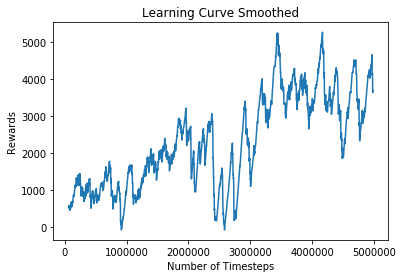

In [0]:

from stable_baselines.results_plotter import load_results, ts2xy

def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')


def plot_results(log_folder, title='Learning Curve'):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), 'timesteps')
    y = moving_average(y, window=50)
    # Truncate x
    x = x[len(x) - len(y):]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Rewards')
    plt.title(title + " Smoothed")
    plt.show()

plot_results('.')


In [0]:
model=PPO2.load('ppo2_random_gaussian_test_charging')
env = RoombaEnv(20, 20, 500, 2, N_grid=2)
env = Monitor_stable_baseline(env, '.', allow_early_resets=True)
env = DummyVecEnv([lambda: env ])

model.set_env(env)
model.learning_rate=2.5e-5
model.learn(total_timesteps=1500000)


Streaming output truncated to the last 5000 lines.
| time_elapsed       | 496            |
| total_timesteps    | 465280         |
| value_loss         | 7747.4756      |
---------------------------------------
--------------------------------------
| approxkl           | 2.5438385e-07 |
| clipfrac           | 0.0           |
| ep_len_mean        | 1.09e+03      |
| ep_reward_mean     | 391           |
| explained_variance | 0.73          |
| fps                | 961           |
| n_updates          | 3636          |
| policy_entropy     | 0.45933586    |
| policy_loss        | -5.816226e-05 |
| serial_timesteps   | 465408        |
| time_elapsed       | 496           |
| total_timesteps    | 465408        |
| value_loss         | 2.003952      |
--------------------------------------
---------------------------------------
| approxkl           | 1.0469779e-05  |
| clipfrac           | 0.0            |
| ep_len_mean        | 1.09e+03       |
| ep_reward_mean     | 391            |
| ex

KeyboardInterrupt: ignored

In [0]:
env = wrap_env(RoombaEnv(20, 20, 500, 2, N_grid=2))
obs = env.reset()
total_reward = 0
for i in range(10000):
    env.render()
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    total_reward+=rewards
    if done:
      break
env.close()
print('total reward: '+str(total_reward))
show_video()

total reward: 2999.0


In [0]:
env = wrap_env(RoombaEnv(40, 40, 1000, 4))
obs = env.reset()
total_reward = 0
for i in range(10000):
    env.render()
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    total_reward+=rewards
    if done:
      break
env.close()
print('total reward: '+str(total_reward))
show_video()

total reward: 9850.0


## DQN

In [0]:

import gym

from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.deepq.policies import MlpPolicy
from stable_baselines import DQN

env = wrap_env(RoombaEnv(20, 20, 500, 2))

model = DQN(CustomPolicy, env,exploration_fraction=0.2, exploration_final_eps=0.02, verbose=1)
model.learn(total_timesteps=1000000)
model.save("EE")

#del model # remove to demonstrate saving and loading
# model = DQN.load("EE")

env.close()

AssertionError: ignored

In [0]:
env = wrap_env(RoombaEnv(20, 20, 500, 2))
obs = env.reset()

while True:
    env.render()
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
      break
env.close()
show_video()

## TRPO

In [0]:
from stable_baselines.common.policies import ActorCriticPolicy, register_policy,  FeedForwardPolicy

def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights



class CustomPolicy(ActorCriticPolicy):
    def __init__(self, sess, ob_space, ac_space, n_env, n_steps, n_batch, reuse=False, **kwargs):
        super(CustomPolicy, self).__init__(sess, ob_space, ac_space, n_env, n_steps, n_batch, reuse=reuse, scale=True)

        with tf.variable_scope("model", reuse=reuse):
            activ = tf.nn.relu

            i = self.processed_obs
            input_roomba = tf.slice(i, [0,0],[-1,4])
            input_map = tf.slice(i,[0,4],[-1, -1])

            input_map = tf.reshape(input_map, [-1,20, 20])
            input_map = tf.expand_dims(input_map, -1)    

            map_features,_ = new_conv_layer(input_map,  1, 3, 8, use_pooling=True)
            map_features,_ = new_conv_layer(map_features,  8, 3, 4, use_pooling=True)

            map_features = tf.layers.flatten(map_features)

            concat_feature = tf.concat([input_roomba, map_features], 1)

            features = activ(tf.layers.dense(concat_feature, 8))

            pi_latent = features

            vf_latent = features
            value_fn = tf.layers.dense(features, 1, name='vf')


            self._proba_distribution, self._policy, self.q_value = \
                self.pdtype.proba_distribution_from_latent(pi_latent, vf_latent, init_scale=0.01)

        self._value_fn = value_fn
        self._setup_init()
        
    def step(self, obs, state=None, mask=None, deterministic=False):
        if deterministic:
            action, value, neglogp = self.sess.run([self.deterministic_action, self.value_flat, self.neglogp],
                                                   {self.obs_ph: obs})
        else:
            action, value, neglogp = self.sess.run([self.action, self.value_flat, self.neglogp],
                                                   {self.obs_ph: obs})
        return action, value, self.initial_state, neglogp

    def proba_step(self, obs, state=None, mask=None):
        return self.sess.run(self.policy_proba, {self.obs_ph: obs})

    def value(self, obs, state=None, mask=None):
        return self.sess.run(self.value_flat, {self.obs_ph: obs})


In [0]:
import gym

from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import TRPO
from stable_baselines.bench import Monitor as Monitor_stable_baseline


env = RoombaEnv(20, 20, 500, 2)
env = Monitor_stable_baseline(env, '.', allow_early_resets=True)

#env = DummyVecEnv([lambda: env  for i in range(10)])

model = TRPO(MlpPolicy, env, verbose=1)
model.learn(total_timesteps=1500000)
env.close()

********** Iteration 0 ************
Optimizing Policy...
sampling


AttributeError: ignored

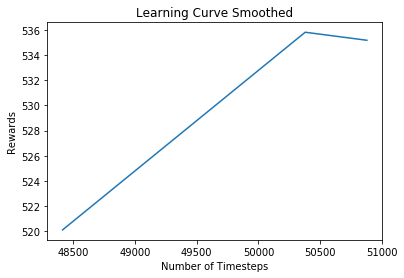

In [0]:

from stable_baselines.results_plotter import load_results, ts2xy

def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')


def plot_results(log_folder, title='Learning Curve'):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), 'timesteps')
    y = moving_average(y, window=50)
    # Truncate x
    x = x[len(x) - len(y):]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Rewards')
    plt.title(title + " Smoothed")
    plt.show()

plot_results('.')


In [0]:
import gym
import tensorflow as tf

from stable_baselines.common.policies import ActorCriticPolicy, register_policy, nature_cnn
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import A2C
from stable_baselines.bench import Monitor as Monitor_stable_baseline


env = RoombaEnv(20, 20, 500, 2)
env = Monitor_stable_baseline(env, '.', allow_early_resets=True)


model = A2C(CustomPolicy, env, verbose=1)
# Train the agent
model.learn(total_timesteps=100000)


Wrapping the env in a DummyVecEnv.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
(?, 104)
Tensor("model/flatten/Reshape:0", shape=(?, 100), dtype=float32)
Tensor("model/Slice:0", shape=(?, 4), dtype=float32)
(?, 104)
Tensor("train_model/model/flatten/Reshape:0", shape=(?, 100), dtype=float32)
Tensor("train_model/model/Slice:0", shape=(?, 4), dtype=float32)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
---------------------------------
| explained_variance | 0.00727  |
| fps                | 29       |
| nupdates           | 1        |
| policy_entropy     | 1.39     |
| total_timesteps    | 5        |
| value_loss         | 63.3     |
---------------------------------
-------------------------

In [0]:
import gym

from stable_baselines.common.policies import MlpPolicy
from stable_baselines import TRPO

env = wrap_env(RoombaEnv(20, 20, 500, 2))

model = TRPO(MlpPolicy, env, verbose=1)
model.learn(total_timesteps=1000000)
model.save("EE2")

env.close()





Instructions for updating:
Use keras.layers.flatten instead.



********** Iteration 0 ************
Optimizing Policy...
sampling
done in 13.189 seconds
computegrad
done in 0.153 seconds
conjugate_gradient
      iter residual norm  soln norm
         0     0.0206          0
         1    0.00291     0.0267
         2    0.00146      0.541
         3    0.00355      0.558
         4   0.000462       1.01
         5    0.00215       1.02
         6   0.000164        1.3
         7   3.43e-05       1.51
         8   2.19e-05       1.57
         9   9.19e-05       1.57
        10   3.76e-06       1.58
done in 0.175 seconds
Expected: 0.034 Actual: 0.029
Stepsize OK!
vf
done in 0.109 seconds
------------------------------------------
| EpLenMean               | 500          |
| EpRewMean               | -77          |
| EpThisIter              | 2            |
| EpisodesSoFar           | 2            |
| TimeElapsed             | 13.7         |
| TimestepsSoFar          | 1024         |


In [0]:
env = wrap_env(RoombaEnv(20, 20, 500, 2))
obs = env.reset()
while True:
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    env.render()
    if done:
      break
env.close()
show_video()

In [0]:
import warnings
from itertools import zip_longest
from abc import ABC, abstractmethod

import numpy as np
import tensorflow as tf
from gym.spaces import Discrete

from stable_baselines.common.distributions import make_proba_dist_type, CategoricalProbabilityDistribution, \
    MultiCategoricalProbabilityDistribution, DiagGaussianProbabilityDistribution, BernoulliProbabilityDistribution
from stable_baselines.common.input import observation_input


def mlp_extractor(flat_observations, net_arch, act_fun):
    """
    Constructs an MLP that receives observations as an input and outputs a latent representation for the policy and
    a value network. The ``net_arch`` parameter allows to specify the amount and size of the hidden layers and how many
    of them are shared between the policy network and the value network. It is assumed to be a list with the following
    structure:

    1. An arbitrary length (zero allowed) number of integers each specifying the number of units in a shared layer.
       If the number of ints is zero, there will be no shared layers.
    2. An optional dict, to specify the following non-shared layers for the value network and the policy network.
       It is formatted like ``dict(vf=[<value layer sizes>], pi=[<policy layer sizes>])``.
       If it is missing any of the keys (pi or vf), no non-shared layers (empty list) is assumed.

    For example to construct a network with one shared layer of size 55 followed by two non-shared layers for the value
    network of size 255 and a single non-shared layer of size 128 for the policy network, the following layers_spec
    would be used: ``[55, dict(vf=[255, 255], pi=[128])]``. A simple shared network topology with two layers of size 128
    would be specified as [128, 128].

    :param flat_observations: (tf.Tensor) The observations to base policy and value function on.
    :param net_arch: ([int or dict]) The specification of the policy and value networks.
        See above for details on its formatting.
    :param act_fun: (tf function) The activation function to use for the networks.
    :return: (tf.Tensor, tf.Tensor) latent_policy, latent_value of the specified network.
        If all layers are shared, then ``latent_policy == latent_value``
    """
    latent = flat_observations
    policy_only_layers = []  # Layer sizes of the network that only belongs to the policy network
    value_only_layers = []  # Layer sizes of the network that only belongs to the value network

    # Iterate through the shared layers and build the shared parts of the network
    for idx, layer in enumerate(net_arch):
        if isinstance(layer, int):  # Check that this is a shared layer
            layer_size = layer
            latent = act_fun(linear(latent, "shared_fc{}".format(idx), layer_size, init_scale=np.sqrt(2)))
        else:
            assert isinstance(layer, dict), "Error: the net_arch list can only contain ints and dicts"
            if 'pi' in layer:
                assert isinstance(layer['pi'], list), "Error: net_arch[-1]['pi'] must contain a list of integers."
                policy_only_layers = layer['pi']

            if 'vf' in layer:
                assert isinstance(layer['vf'], list), "Error: net_arch[-1]['vf'] must contain a list of integers."
                value_only_layers = layer['vf']
            break  # From here on the network splits up in policy and value network

    # Build the non-shared part of the network
    latent_policy = latent
    latent_value = latent
    for idx, (pi_layer_size, vf_layer_size) in enumerate(zip_longest(policy_only_layers, value_only_layers)):
        if pi_layer_size is not None:
            assert isinstance(pi_layer_size, int), "Error: net_arch[-1]['pi'] must only contain integers."
            latent_policy = act_fun(linear(latent_policy, "pi_fc{}".format(idx), pi_layer_size, init_scale=np.sqrt(2)))

        if vf_layer_size is not None:
            assert isinstance(vf_layer_size, int), "Error: net_arch[-1]['vf'] must only contain integers."
            latent_value = act_fun(linear(latent_value, "vf_fc{}".format(idx), vf_layer_size, init_scale=np.sqrt(2)))

    return latent_policy, latent_value

class BasePolicy(ABC):
    """
    The base policy object

    :param sess: (TensorFlow session) The current TensorFlow session
    :param ob_space: (Gym Space) The observation space of the environment
    :param ac_space: (Gym Space) The action space of the environment
    :param n_env: (int) The number of environments to run
    :param n_steps: (int) The number of steps to run for each environment
    :param n_batch: (int) The number of batches to run (n_envs * n_steps)
    :param reuse: (bool) If the policy is reusable or not
    :param scale: (bool) whether or not to scale the input
    :param obs_phs: (TensorFlow Tensor, TensorFlow Tensor) a tuple containing an override for observation placeholder
        and the processed observation placeholder respectively
    :param add_action_ph: (bool) whether or not to create an action placeholder
    """

    recurrent = False

    def __init__(self, sess, ob_space, ac_space, n_env, n_steps, n_batch, reuse=False, scale=False,
                 obs_phs=None, add_action_ph=False):
        self.n_env = n_env
        self.n_steps = n_steps
        self.n_batch = n_batch
        with tf.variable_scope("input", reuse=False):
            if obs_phs is None:
                self._obs_ph, self._processed_obs = observation_input(ob_space, n_batch, scale=scale)
            else:
                self._obs_ph, self._processed_obs = obs_phs

            self._action_ph = None
            if add_action_ph:
                self._action_ph = tf.placeholder(dtype=ac_space.dtype, shape=(n_batch,) + ac_space.shape,
                                                 name="action_ph")
        self.sess = sess
        self.reuse = reuse
        self.ob_space = ob_space
        self.ac_space = ac_space

    @property
    def is_discrete(self):
        """bool: is action space discrete."""
        return isinstance(self.ac_space, Discrete)

    @property
    def initial_state(self):
        """
        The initial state of the policy. For feedforward policies, None. For a recurrent policy,
        a NumPy array of shape (self.n_env, ) + state_shape.
        """
        assert not self.recurrent, "When using recurrent policies, you must overwrite `initial_state()` method"
        return None

    @property
    def get_obs_ph(self):
        """tf.Tensor: placeholder for observations, shape (self.n_batch, ) + self.ob_space.shape."""
        return self._obs_ph

    @property
    def get_processed_obs(self):
        """tf.Tensor: processed observations, shape (self.n_batch, ) + self.ob_space.shape.

        The form of processing depends on the type of the observation space, and the parameters
        whether scale is passed to the constructor; see observation_input for more information."""
        return self._processed_obs

    @property
    def action_ph(self):
        """tf.Tensor: placeholder for actions, shape (self.n_batch, ) + self.ac_space.shape."""
        return self._action_ph

    @staticmethod
    def _kwargs_check(feature_extraction, kwargs):
        """
        Ensure that the user is not passing wrong keywords
        when using policy_kwargs.

        :param feature_extraction: (str)
        :param kwargs: (dict)
        """
        # When using policy_kwargs parameter on model creation,
        # all keywords arguments must be consumed by the policy constructor except
        # the ones for the cnn_extractor network (cf nature_cnn()), where the keywords arguments
        # are not passed explicitly (using **kwargs to forward the arguments)
        # that's why there should be not kwargs left when using the mlp_extractor
        # (in that case the keywords arguments are passed explicitly)
        if feature_extraction == 'mlp' and len(kwargs) > 0:
            raise ValueError("Unknown keywords for policy: {}".format(kwargs))

    @abstractmethod
    def step(self, obs, state=None, mask=None):
        """
        Returns the policy for a single step

        :param obs: ([float] or [int]) The current observation of the environment
        :param state: ([float]) The last states (used in recurrent policies)
        :param mask: ([float]) The last masks (used in recurrent policies)
        :return: ([float], [float], [float], [float]) actions, values, states, neglogp
        """
        raise NotImplementedError

    @abstractmethod
    def proba_step(self, obs, state=None, mask=None):
        """
        Returns the action probability for a single step

        :param obs: ([float] or [int]) The current observation of the environment
        :param state: ([float]) The last states (used in recurrent policies)
        :param mask: ([float]) The last masks (used in recurrent policies)
        :return: ([float]) the action probability
        """
        raise NotImplementedError

class ActorCriticPolicy(BasePolicy):
    """
    Policy object that implements actor critic

    :param sess: (TensorFlow session) The current TensorFlow session
    :param ob_space: (Gym Space) The observation space of the environment
    :param ac_space: (Gym Space) The action space of the environment
    :param n_env: (int) The number of environments to run
    :param n_steps: (int) The number of steps to run for each environment
    :param n_batch: (int) The number of batch to run (n_envs * n_steps)
    :param reuse: (bool) If the policy is reusable or not
    :param scale: (bool) whether or not to scale the input
    """

    def __init__(self, sess, ob_space, ac_space, n_env, n_steps, n_batch, reuse=False, scale=False):
        BasePolicy.__init__(sess, ob_space, ac_space, n_env, n_steps, n_batch, reuse=reuse,
                                                scale=scale, obs_phs=None)
        self._pdtype = make_proba_dist_type(ac_space)
        self._policy = None
        self._proba_distribution = None
        self._value_fn = None
        self._action = None
        self._deterministic_action = None
        self._processed_obs = super()._processed_obs

    def _setup_init(self):
        """Sets up the distributions, actions, and value."""
        with tf.variable_scope("output", reuse=True):
            assert self.policy is not None and self.proba_distribution is not None and self.value_fn is not None
            self._action = self.proba_distribution.sample()
            self._deterministic_action = self.proba_distribution.mode()
            self._neglogp = self.proba_distribution.neglogp(self.action)
            if isinstance(self.proba_distribution, CategoricalProbabilityDistribution):
                self._policy_proba = tf.nn.softmax(self.policy)
            elif isinstance(self.proba_distribution, DiagGaussianProbabilityDistribution):
                self._policy_proba = [self.proba_distribution.mean, self.proba_distribution.std]
            elif isinstance(self.proba_distribution, BernoulliProbabilityDistribution):
                self._policy_proba = tf.nn.sigmoid(self.policy)
            elif isinstance(self.proba_distribution, MultiCategoricalProbabilityDistribution):
                self._policy_proba = [tf.nn.softmax(categorical.flatparam())
                                     for categorical in self.proba_distribution.categoricals]
            else:
                self._policy_proba = []  # it will return nothing, as it is not implemented
            self._value_flat = self.value_fn[:, 0]

    @property
    def pdtype(self):
        """ProbabilityDistributionType: type of the distribution for stochastic actions."""
        return self._pdtype

    @property
    def policy(self):
        """tf.Tensor: policy output, e.g. logits."""
        return self._policy

    @property
    def proba_distribution(self):
        """ProbabilityDistribution: distribution of stochastic actions."""
        return self._proba_distribution

    @property
    def value_fn(self):
        """tf.Tensor: value estimate, of shape (self.n_batch, 1)"""
        return self._value_fn

    @property
    def value_flat(self):
        """tf.Tensor: value estimate, of shape (self.n_batch, )"""
        return self._value_flat

    @property
    def action(self):
        """tf.Tensor: stochastic action, of shape (self.n_batch, ) + self.ac_space.shape."""
        return self._action

    @property
    def deterministic_action(self):
        """tf.Tensor: deterministic action, of shape (self.n_batch, ) + self.ac_space.shape."""
        return self._deterministic_action

    @property
    def neglogp(self):
        """tf.Tensor: negative log likelihood of the action sampled by self.action."""
        return self._neglogp

    @property
    def policy_proba(self):
        """tf.Tensor: parameters of the probability distribution. Depends on pdtype."""
        return self._policy_proba

    @abstractmethod
    def step(self, obs, state=None, mask=None, deterministic=False):
        """
        Returns the policy for a single step

        :param obs: ([float] or [int]) The current observation of the environment
        :param state: ([float]) The last states (used in recurrent policies)
        :param mask: ([float]) The last masks (used in recurrent policies)
        :param deterministic: (bool) Whether or not to return deterministic actions.
        :return: ([float], [float], [float], [float]) actions, values, states, neglogp
        """
        raise NotImplementedError

    @abstractmethod
    def value(self, obs, state=None, mask=None):
        """
        Returns the value for a single step

        :param obs: ([float] or [int]) The current observation of the environment
        :param state: ([float]) The last states (used in recurrent policies)
        :param mask: ([float]) The last masks (used in recurrent policies)
        :return: ([float]) The associated value of the action
        """
        raise NotImplementedError

## A2C

In [0]:
import gym

from stable_baselines.common.vec_env import VecFrameStack

from stable_baselines.common.policies import MlpPolicy, CnnPolicy
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import A2C
from stable_baselines.bench import Monitor as Monitor_stable_baseline

env = wrap_env(RoombaEnv(40, 40, 500, 2))
env = Monitor_stable_baseline(env, '.', allow_early_resets=True)

env = DummyVecEnv([lambda: env ])

env = VecFrameStack(env, n_stack=4)

model = A2C('CnnPolicy', env, verbose=1)
model.learn(total_timesteps=25000*10)

Streaming output truncated to the last 5000 lines.
| ep_len_mean        | 500       |
| ep_reward_mean     | -172      |
| explained_variance | -0.000108 |
| fps                | 30        |
| nupdates           | 100       |
| policy_entropy     | 1.39      |
| total_timesteps    | 500       |
| value_loss         | 3.72e+04  |
----------------------------------
---------------------------------
| ep_len_mean        | 500      |
| ep_reward_mean     | -178     |
| explained_variance | -0.00153 |
| fps                | 31       |
| nupdates           | 200      |
| policy_entropy     | 1.39     |
| total_timesteps    | 1000     |
| value_loss         | 3.85e+04 |
---------------------------------
----------------------------------
| ep_len_mean        | 500       |
| ep_reward_mean     | -132      |
| explained_variance | -1.19e-07 |
| fps                | 45        |
| nupdates           | 300       |
| policy_entropy     | 1.39      |
| total_timesteps    | 1500      |
| value_loss  

In [0]:
import gym
import tensorflow as tf

from stable_baselines.common.policies import ActorCriticPolicy, register_policy, nature_cnn
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import A2C
from stable_baselines.bench import Monitor as Monitor_stable_baseline
from stable_baselines.common.input import observation_input
from stable_baselines.common.distributions import make_proba_dist_type

# Custom MLP policy of three layers of size 128 each for the actor and 2 layers of 32 for the critic,
# with a nature_cnn feature extractor
class CustomPolicy(ActorCriticPolicy):
    def __init__(self, sess, ob_space, ac_space, n_env, n_steps, n_batch, reuse=False, **kwargs):
        ActorCriticPolicy.__init__(self, sess, ob_space, ac_space, n_env, n_steps, n_batch, reuse=reuse, scale=False)
        print(ActorCriticPolicy._processed_obs)
        with tf.variable_scope("model", reuse=reuse):
            activ = tf.nn.relu
            extracted_features = nature_cnn(self._processed_obs, **kwargs)
            extracted_features = tf.layers.flatten(extracted_features)

            pi_h = extracted_features
            for i, layer_size in enumerate([128, 128, 128]):
                pi_h = activ(tf.layers.dense(pi_h, layer_size, name='pi_fc' + str(i)))
            pi_latent = pi_h

            vf_h = extracted_features
            for i, layer_size in enumerate([32, 32]):
                vf_h = activ(tf.layers.dense(vf_h, layer_size, name='vf_fc' + str(i)))
            value_fn = tf.layers.dense(vf_h, 1, name='vf')
            vf_latent = vf_h

            self._proba_distribution, self._policy, self.q_value = \
                self.pdtype.proba_distribution_from_latent(pi_latent, vf_latent, init_scale=0.01)

        self._value_fn = value_fn
        self._setup_init()

    def step(self, obs, state=None, mask=None, deterministic=False):
        if deterministic:
            action, value, neglogp = self.sess.run([self.deterministic_action, self.value_flat, self.neglogp],
                                                   {self.obs_ph: obs})
        else:
            action, value, neglogp = self.sess.run([self.action, self.value_flat, self.neglogp],
                                                   {self.obs_ph: obs})
        return action, value, self.initial_state, neglogp

    def proba_step(self, obs, state=None, mask=None):
        return self.sess.run(self.policy_proba, {self.obs_ph: obs})

    def value(self, obs, state=None, mask=None):
        return self.sess.run(self.value_flat, {self.obs_ph: obs})

env = wrap_env(RoombaEnv(20, 20, 500, 2))
env = Monitor_stable_baseline(env, '.', allow_early_resets=True)

env = DummyVecEnv([lambda: env ])

model = A2C(CustomPolicy, env, verbose=1)
# Train the agent
model.learn(total_timesteps=100000*3)

AttributeError: ignored

In [0]:
#With Map
import gym

from stable_baselines.common.policies import MlpPolicy, CnnPolicy
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import A2C
from stable_baselines.bench import Monitor as Monitor_stable_baseline

env = wrap_env(RoombaEnv(20, 20, 500, 2))
env = Monitor_stable_baseline(env, '.', allow_early_resets=True)

env = DummyVecEnv([lambda: env ])

model = A2C(CnnPolicy, env, verbose=1)
model.learn(total_timesteps=500000*4)
model.save("EE3")

ValueError: ignored

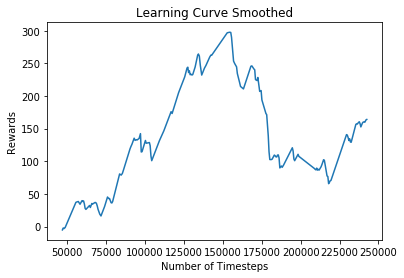

In [0]:
from stable_baselines.results_plotter import load_results, ts2xy

def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')


def plot_results(log_folder, title='Learning Curve'):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), 'timesteps')
    y = moving_average(y, window=50)
    # Truncate x
    x = x[len(x) - len(y):]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Rewards')
    plt.title(title + " Smoothed")
    plt.show()

plot_results('.')


In [0]:
env = wrap_env(RoombaEnv(20, 20, 500, 2))
obs = env.reset()
while True:
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    env.render()
    if done:
      break
env.close()
show_video()

In [0]:
from stable_baselines.common.policies import FeedForwardPolicy, register_policy
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import A2C
from stable_baselines.bench import Monitor as Monitor_stable_baseline

# Custom MLP policy of three layers of size 128 each
class CustomPolicy(FeedForwardPolicy):
    def __init__(self, *args, **kwargs):
        super(CustomPolicy, self).__init__(*args, **kwargs,
                                           net_arch=[dict(pi=[16, 32, 16],
                                                          vf=[16, 32, 16])],
                                           feature_extraction="mlp")

# Create and wrap the environment
env = wrap_env(RoombaEnv(20, 20, 500, 2))
env = Monitor_stable_baseline(env, '.', allow_early_resets=True)

env = DummyVecEnv([lambda: env])

model = A2C(CustomPolicy, env, verbose=1)
# Train the agent
model.learn(total_timesteps=500000*4)
# Save the agent
model.save("lalala")


Streaming output truncated to the last 5000 lines.
| explained_variance | 0.178    |
| fps                | 1024     |
| nupdates           | 337600   |
| policy_entropy     | 0.292    |
| total_timesteps    | 1688000  |
| value_loss         | 55.1     |
---------------------------------
---------------------------------
| explained_variance | 0.74     |
| fps                | 1024     |
| nupdates           | 337700   |
| policy_entropy     | 0.414    |
| total_timesteps    | 1688500  |
| value_loss         | 6.29     |
---------------------------------
---------------------------------
| explained_variance | 0.229    |
| fps                | 1024     |
| nupdates           | 337800   |
| policy_entropy     | 0.138    |
| total_timesteps    | 1689000  |
| value_loss         | 23       |
---------------------------------
---------------------------------
| explained_variance | 0.216    |
| fps                | 1024     |
| nupdates           | 337900   |
| policy_entropy     | 0.629   

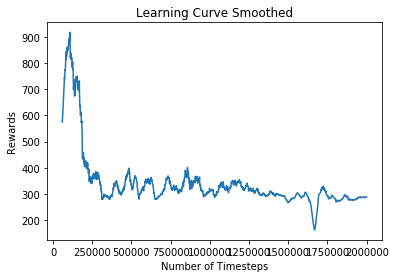

In [0]:
from stable_baselines.results_plotter import load_results, ts2xy

def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')


def plot_results(log_folder, title='Learning Curve'):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), 'timesteps')
    y = moving_average(y, window=50)
    # Truncate x
    x = x[len(x) - len(y):]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Rewards')
    plt.title(title + " Smoothed")
    plt.show()

plot_results('.')


In [0]:
env = wrap_env(RoombaEnv(20, 20, 500, 2))
obs = env.reset()
while True:
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    env.render()
    if done:
      break
env.close()
show_video()

## GAIL

In [0]:
import gym

from stable_baselines import GAIL, A2C
from stable_baselines.gail import ExpertDataset, generate_expert_traj

# Generate expert trajectories (train expert)
env = wrap_env(RoombaEnv(20, 20, 500, 2))

model = A2C(MlpPolicy, env, verbose=1)
generate_expert_traj(model, 'expert_roomba', n_timesteps=20000, n_episodes=10)

# Load the expert dataset
dataset = ExpertDataset(expert_path='expert_roomba.npz', traj_limitation=20000, verbose=1)

model = GAIL('MlpPolicy', env, dataset, verbose=1)
# Note: in practice, you need to train for 1M steps to have a working policy
model.learn(total_timesteps=50000)
model.save("gail_roomba")

env.close()

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



ImportError: ignored

In [0]:
env = wrap_env(RoombaEnv(20, 20, 500, 2))
obs = env.reset()
while True:
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    env.render()
    if done:
      break
env.close()
show_video()

## ACER

In [0]:
from stable_baselines.common.cmd_util import make_atari_env
from stable_baselines.common.vec_env import VecFrameStack
from stable_baselines import ACER
from stable_baselines.bench import Monitor as Monitor_stable_baseline
from stable_baselines.common.vec_env import DummyVecEnv

env = wrap_env(RoombaEnv(40, 40, 500, 2))
env = Monitor_stable_baseline(env, '.', allow_early_resets=True)

env = DummyVecEnv([lambda: env ])

env = VecFrameStack(env, n_stack=4)

model = ACER('CnnPolicy', env, verbose=1)
model.learn(total_timesteps=25000*10)

-----------------------------------
| avg_norm_adj        | 0         |
| avg_norm_g          | 0.000269  |
| avg_norm_grads_f    | 0.000269  |
| avg_norm_k          | 2         |
| avg_norm_k_dot_g    | 0.000269  |
| entropy             | 29.1      |
| explained_variance  | 0.198     |
| fps                 | 0         |
| loss                | -0.291    |
| loss_bc             | -0        |
| loss_f              | -8.13e-05 |
| loss_policy         | -8.13e-05 |
| loss_q              | 3.79e-09  |
| mean_episode_length | 0         |
| mean_episode_reward | 0         |
| norm_grads          | 2.22e-05  |
| norm_grads_policy   | 1.28e-05  |
| norm_grads_q        | 1.81e-05  |
| total_timesteps     | 0         |
-----------------------------------
----------------------------------
| avg_norm_adj        | 0        |
| avg_norm_g          | 0.0334   |
| avg_norm_grads_f    | 0.0334   |
| avg_norm_k          | 2        |
| avg_norm_k_dot_g    | 0.0334   |
| entropy             | 29.1     |

In [0]:
env = wrap_env(RoombaEnv(40, 40, 500, 2))
obs = env.reset()

print(env.observation_space.shape)

while True:
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    env.render()
    if done:
      break
env.close()
show_video()

(40, 40, 1)


ValueError: ignored

In [0]:
from stable_baselines.common.env_checker import check_env

env = RoombaEnv(40, 40, 500, 2)
print(env.observation_space.shape)
# It will check your custom environment and output additional warnings if needed
check_env(env)

(40, 40, 1)


## ACKTR

In [0]:
import gym

from stable_baselines.common.policies import MlpPolicy, MlpLstmPolicy, MlpLnLstmPolicy
from stable_baselines.common import make_vec_env
from stable_baselines import ACKTR

env = wrap_env(RoombaEnv(20, 20, 500, 2))

model = ACKTR(MlpPolicy, env, verbose=1)
model.learn(total_timesteps=50000)
model.save("E5")

Wrapping the env in a DummyVecEnv.
---------------------------------
| explained_variance | 0.00369  |
| fps                | 21       |
| nupdates           | 1        |
| policy_entropy     | 1.39     |
| policy_loss        | 12       |
| total_timesteps    | 0        |
| value_loss         | 137      |
---------------------------------
---------------------------------
| explained_variance | 0.0237   |
| fps                | 68       |
| nupdates           | 100      |
| policy_entropy     | 1.15     |
| policy_loss        | 10.1     |
| total_timesteps    | 2079     |
| value_loss         | 214      |
---------------------------------
---------------------------------
| explained_variance | -0.0084  |
| fps                | 101      |
| nupdates           | 200      |
| policy_entropy     | 0.642    |
| policy_loss        | -0.232   |
| total_timesteps    | 4179     |
| value_loss         | 0.213    |
---------------------------------
---------------------------------
| explained_v

In [0]:
env = wrap_env(RoombaEnv(20, 20, 500, 2))
obs = env.reset()
while True:
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    env.render()
    if done:
      break
env.close()
show_video()

In [0]:
#TODO replace by this the repetitions!
def assess(model, env):
  obs = env.reset()
  while True:
      action, _states = model.predict(obs)
      obs, rewards, done, info = env.step(action)
      env.render()
      if done:
        break
  env.close()
  show_video()